In [2]:
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Input
from tensorflow.keras.models import Model, Sequential, save_model, load_model
from sklearn.metrics import roc_curve, roc_auc_score

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam, SGD

from keras.utils import np_utils

import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import os

import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

import pickle

In [3]:
def plot_history(history, yrange):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [6]:
fh = open('/Users/home/Documents/Respiratory Illness AI/datasets/copd_asthma_224_224_3', 'rb')
dataset = pickle.load(fh)

In [7]:
print(dataset)

[(array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+

In [9]:
input_shape = (224, 224, 3)

In [17]:
# random.shuffle(dataset)
train = dataset[:130]
val = dataset[130:170]
# test = dataset[165:]

X_train, y_train = zip(*train)
X_val, y_val = zip(*val)
# X_test, y_test = zip(*test)

X_train = np.array([x.reshape(input_shape) for x in X_train])
X_val = np.array([x.reshape(input_shape) for x in X_val])
# X_test = np.array([x.reshape(input_shape) for x in X_test])

print(X_train[0].shape)

y_train = np.array(np_utils.to_categorical(y_train, 2))
y_val = np.array(np_utils.to_categorical(y_val, 2))
# y_test = np.array(np_utils.to_categorical(y_test, 2))

print(y_train[0].shape)

(224, 224, 3)
(2,)


In [18]:
dropout_rates = [0.5, 0.6, 0.7, 0.8]
activations = ['relu', 'sigmoid']

In [19]:
baseModel = ResNet50(weights=None, include_top=False, input_shape=input_shape)

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)

headModel = Dense(512, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)

headModel = Dense(512, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)

headModel = Dense(512, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)

headModel = Dense(2, activation="sigmoid")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

2022-12-30 15:09:06.152408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
model.compile(optimizer="Adam", 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x=X_train,
          y=y_train,
          epochs=25,
          batch_size=15,
          validation_data=(X_val, y_val))

Epoch 1/25
1/9 [==>...........................] - ETA: 1:57 - loss: 0.6795 - accuracy: 0.4667

KeyboardInterrupt: 

In [11]:
score = model.evaluate(x=X_val,
                     y=y_val)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 6s 902ms/step - loss: 0.5133 - accuracy: 0.8250
Test loss: 0.5133089423179626
Test accuracy: 0.824999988079071


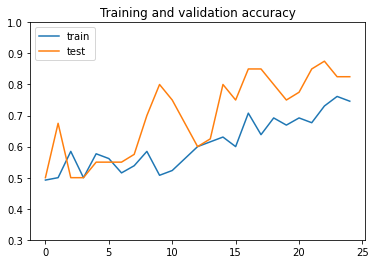

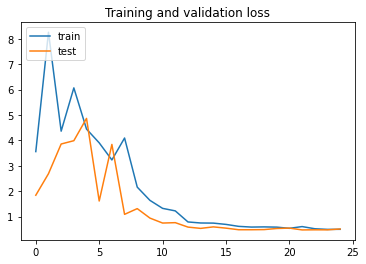

In [12]:
plot_history(history, (0.3, 1))

In [13]:
y_score = model.predict(X_val)
# false_positive_rate, true_positive_rate, threshold = roc_curve(y_val, y_score)
print('roc_auc_score: ', roc_auc_score(y_val, y_score))

roc_auc_score:  0.8232323232323233


In [14]:
save_model(model, 
           'rESnET_82-2', 
           overwrite=True, 
           include_optimizer=True, 
           save_format=None, 
           signatures=None, options=None, save_traces=True)

2022-02-09 18:24:45.458393: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: rESnET_82-2/assets
